<a href="https://colab.research.google.com/github/pranavkantgaur/curves_and_surfaces/blob/master/curves_surfaces_monolithic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## What are curves and surfaces?

In [ ]:
!pip install bezier geomdl

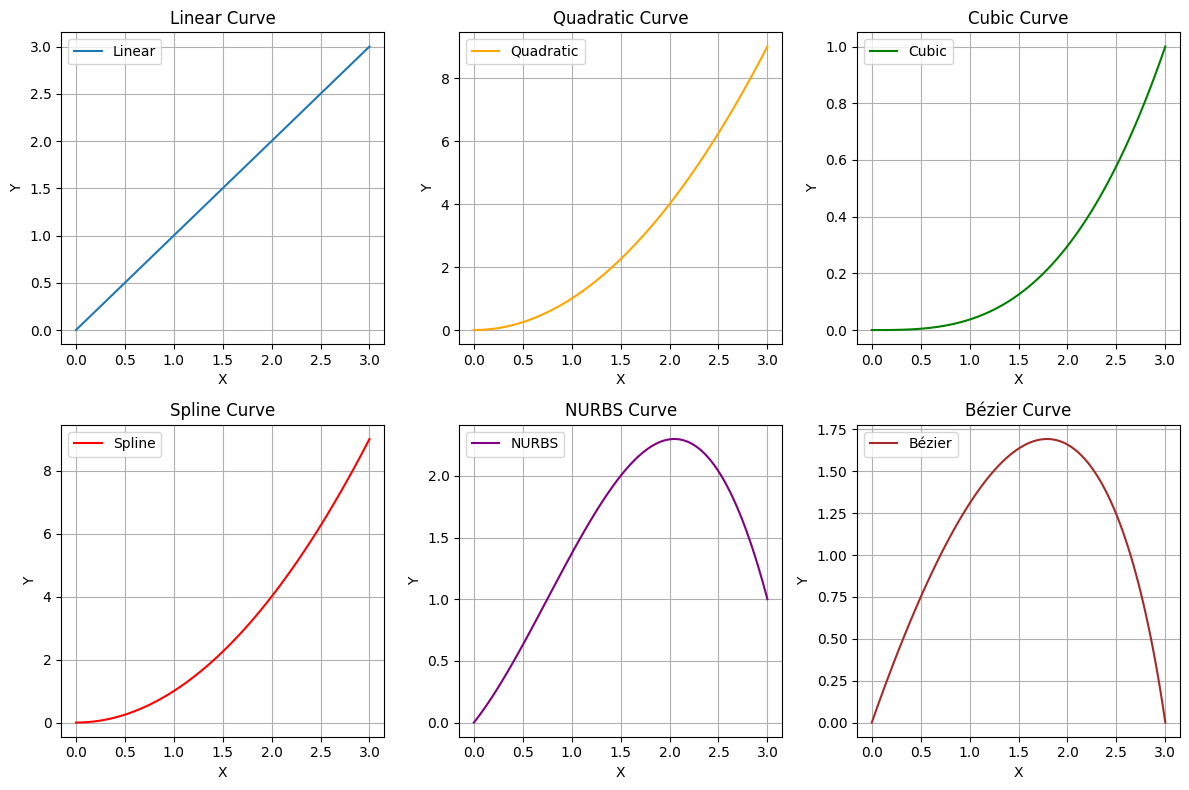

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import bezier  # Ensure you have the bezier library installed
from geomdl import BSpline, utilities

# Sample data points
x_data = np.array([0, 1, 2, 3])
y_data = np.array([0, 1, 4, 9])  # Quadratic function y = x^2

# Prepare a fine grid for plotting curves
x_fine = np.linspace(0, 3, 100)

# Linear Curve
y_linear = x_fine

# Quadratic Curve
y_quadratic = x_fine**2

# Cubic Curve
y_cubic = (x_fine**3) / 27  # Scale for better visualization

# Spline Curve
spline_tck = interpolate.splrep(x_data, y_data)
y_spline = interpolate.splev(x_fine, spline_tck)

# NURBS Curve (using geomdl)
nurbs_curve = BSpline.Curve()
nurbs_curve.degree = 3
nurbs_curve.ctrlpts = [[0, 0], [1, 1], [2, 4], [3, 1]]  # Control points for NURBS
nurbs_curve.knotvector = utilities.generate_knot_vector(nurbs_curve.degree, len(nurbs_curve.ctrlpts))
# Set evaluation delta: This is the crucial step to fix the error
nurbs_curve.delta = 0.01  # Adjust as needed for the desired number of points
nurbs_points = nurbs_curve.evalpts  # Access the evaluated points directly using evalpts
x_nurbs = [pt[0] for pt in nurbs_points] # Extract x-coordinates
y_nurbs = [pt[1] for pt in nurbs_points] # Extract y-coordinates

# Bézier Curve (using bezier library)
bezier_nodes = np.array([[0, 0], [1.5, 2.5], [2.5, 2], [3, 0]])  # Control points for Bézier curve
bezier_curve = bezier.Curve(bezier_nodes.T, degree=len(bezier_nodes) - 1)
s_vals = np.linspace(0.0, 1.0, num=100)
bezier_points = bezier_curve.evaluate_multi(s_vals)
x_bezier = bezier_points[0, :] # Extract x-coordinates
y_bezier = bezier_points[1, :] # Extract y-coordinates

# Plotting all curves
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.plot(x_fine, y_linear, label='Linear')
plt.title('Linear Curve')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(x_fine, y_quadratic, label='Quadratic', color='orange')
plt.title('Quadratic Curve')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(x_fine, y_cubic, label='Cubic', color='green')
plt.title('Cubic Curve')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(x_fine, y_spline, label='Spline', color='red')
plt.title('Spline Curve')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(x_nurbs, y_nurbs, label='NURBS', color='purple')
plt.title('NURBS Curve')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()

plt.subplot(2, 3, 6)
plt.plot(x_bezier, y_bezier,label='Bézier', color='brown')
plt.title('Bézier Curve')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

**Explicit Representation**: This form defines a relationship where one variable is expressed directly in terms of another, typically as $$ y = f(x) $$. For example, the equation of a line can be represented as $$ y = mx + b $$.

```python
def explicit_line(x):
    m = 2  # slope
    b = 1  # y-intercept
    return m * x + b

print(explicit_line(3))  # Output: 7
```

**Implicit Representation**: Here, the relationship is defined implicitly by an equation $$ F(x, y) = 0 $$. For instance, the circle equation $$ (x - a)^2 + (y - b)^2 - r^2 = 0 $$ is implicit.

```python
def implicit_circle(x, y, a=0, b=0, r=1):
    return (x - a)**2 + (y - b)**2 - r**2

print(implicit_circle(1, 1))  # Output: -1 (inside the circle)
```

**Parametric Representation**: This form expresses coordinates as functions of one or more parameters, such as $$ x = g(t) $$ and $$ y = h(t) $$. A common example is the parametric equations for a circle.

```python
import numpy as np

def parametric_circle(t, r=1):
    x = r * np.cos(t)
    y = r * np.sin(t)
    return x, y

print(parametric_circle(np.pi/4))  # Output: (0.707..., 0.707...)
```


Let's explore how explicit, implicit, and parametric representations can be applied in solving the neutron transport equation (NTE) in reactor physics. Each representation can be utilized in different contexts of the NTE, such as modeling neutron flux, calculating neutron density, or tracking neutron behavior over time.

### 1. Explicit Representation

In an explicit representation, we can model the neutron flux directly as a function of position and time. For example, we can use a simple one-dimensional diffusion approximation of the NTE.

#### Example: Neutron Flux Calculation

```python
import numpy as np
import matplotlib.pyplot as plt

def explicit_neutron_flux(x, D, source_strength):
    """ Calculate neutron flux using an explicit representation. """
    return source_strength / (2 * D) * (L - x)  # Linear decay model

# Parameters
L = 10  # Length of the reactor (cm)
D = 0.5  # Diffusion coefficient (cm^2/s)
source_strength = 1.0  # Source strength (neutrons/cm^3)

# Spatial points
x = np.linspace(0, L, 100)
flux = explicit_neutron_flux(x, D, source_strength)

# Plotting the neutron flux
plt.plot(x, flux)
plt.title('Neutron Flux using Explicit Representation')
plt.xlabel('Position (cm)')
plt.ylabel('Flux (neutrons/cm^2)')
plt.grid()
plt.show()
```

### 2. Implicit Representation

An implicit representation can be used to model the steady-state solution of the NTE where we set up a system of equations based on the neutron balance.

The **neutron balance equation** is a fundamental concept in nuclear physics and reactor theory, representing the conservation of neutrons within a defined volume. This equation accounts for the various processes that affect neutron density, including production, absorption, and leakage.

## Neutron Balance Equation

The neutron balance equation can be expressed mathematically as:

$$
\frac{\partial n}{\partial t} = s - \Sigma_a \phi - \nabla \cdot J
$$

Where:
- $$ n $$ is the **neutron density** (number of neutrons per unit volume).
- $$ s $$ is the **source term**, representing the rate at which neutrons are produced from fission or external sources.
- $$ \Sigma_a $$ is the **macroscopic absorption cross-section**, indicating the likelihood of neutrons being absorbed by materials in the reactor.
- $$ \phi $$ is the **neutron flux**, which measures the flow of neutrons through a unit area.
- $$ J $$ is the **neutron current density vector**, describing the flow of neutrons in space.

### Components Explained

1. **Production Rate**: This term accounts for neutrons generated from fission reactions or other sources. It can be expressed as $$ s = \nu \Sigma_f \phi $$, where $$ \nu $$ is the average number of neutrons produced per fission and $$ \Sigma_f $$ is the macroscopic fission cross-section[1][3].

2. **Absorption Rate**: This term, represented by $$ \Sigma_a \phi $$, quantifies how many neutrons are absorbed by materials within the reactor, such as fuel or control rods.

3. **Leakage Rate**: The term $$ -\nabla \cdot J $$ describes how neutrons leave the defined volume, which can occur due to diffusion or other transport phenomena.

## Steady-State Condition

In steady-state conditions, where neutron density does not change with time ($$\frac{\partial n}{\partial t} = 0$$), the equation simplifies to:

$$
0 = s - \Sigma_a \phi - \nabla \cdot J
$$

This indicates that the total production of neutrons equals their total loss through absorption and leakage[1][2].

## Applications

The neutron balance equation is crucial in:
- **Nuclear Reactor Design**: Ensuring that reactors maintain criticality, where neutron production equals losses.
- **Neutron Transport Theory**: Understanding how neutrons move through different materials and how this affects reactor behavior.
- **Safety Analysis**: Evaluating potential scenarios for neutron behavior under various operational conditions.

By analyzing these terms and their relationships, engineers and physicists can predict and control reactor dynamics effectively.




#### Example: Neutron Balance Equation

```python
from scipy.optimize import fsolve

def implicit_neutron_balance(N, alpha, beta):
    """ Neutron balance equation: N - alpha * N - beta = 0 """
    return N - alpha * N - beta

# Parameters
alpha = 0.1  # Absorption coefficient
beta = 5     # Source term

# Initial guess for neutron population
N_initial = 100

# Finding the balance point (root finding)
neutron_balance = fsolve(implicit_neutron_balance, N_initial, args=(alpha, beta))
print(f"Steady-state neutron population: {neutron_balance[0]}")  # Output: Neutron population at balance
```

### 3. Parametric Representation

In a parametric representation, we can express the neutron density as a function of time and space parameters. This approach is useful for simulating how the neutron density evolves in a reactor over time.

#### Example: Time Evolution of Neutron Density

```python
import numpy as np
import matplotlib.pyplot as plt

def parametric_neutron_density(S0, k, t):
    """ Calculate neutron density over time using parametric representation. """
    return S0 * (k ** t)

# Parameters
S0 = 1      # Initial source of neutrons
k = 1.05    # Multiplication factor (5% increase per generation)
time_steps = np.arange(0, 10)  # Simulating for 10 generations

# Calculate neutron density over time
neutron_density = [parametric_neutron_density(S0, k, t) for t in time_steps]

# Plotting neutron density over generations
plt.plot(time_steps, neutron_density)
plt.title('Neutron Density Over Time')
plt.xlabel('Generations')
plt.ylabel('Neutron Density')
plt.grid()
plt.show()
```

### Summary

- **Explicit Representation**: Used to calculate neutron flux directly based on position and diffusion coefficient.
- **Implicit Representation**: Models the steady-state neutron balance equation to find equilibrium conditions.
- **Parametric Representation**: Simulates the evolution of neutron density over time based on an initial source and multiplication factor.

These examples illustrate how explicit, implicit, and parametric representations can be effectively applied to solve aspects of the neutron transport equation in reactor physics. Each method provides insights into different characteristics of neutron behavior within a reactor system.

## A running example
#### Developing ML model for nuclear cross-section estimation
* Scenario 1: The experimental dataset has cross-section values as a function of only energy. In this case, users can augment the dataset using various 1D curve generation methods.
* Scenario 2: The experimental dataset has cross-section values as a function of both energy and temperature. Here, users can augment the dataset using various 2D surface generation methods.

#### Real datasets
* https://www-nds.iaea.org/exfor/x4stat/exfor_stat.htm

#### Lets explore potential of these interpolation methods over real dataset (12k entries)

In [ ]:
!pip install bezier==0.2.1

In [ ]:
from bezier.surface import Surface # Surface is in a submodule of bezier

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import argparse

# Function to perform 1D data augmentation using different curve generation methods
def augment_data_1d(energy_data, cross_section_data, method='spline'):
    energy_fine = np.linspace(min(energy_data), max(energy_data), num=100)

    if method == 'linear':
        augmented_cross_sections = np.interp(energy_fine, energy_data, cross_section_data)
    elif method == 'spline':
        # Sort energy_data and cross_section_data based on energy_data
        sorted_indices = np.argsort(energy_data)
        energy_data_sorted = energy_data[sorted_indices]
        cross_section_data_sorted = cross_section_data[sorted_indices]

        # Remove duplicate energy values and corresponding cross-sections
        energy_data_unique, unique_indices = np.unique(energy_data_sorted, return_index=True)
        cross_section_data_unique = cross_section_data_sorted[unique_indices]

        # Perform spline interpolation with unique and sorted data
        spline_tck = interpolate.splrep(energy_data_unique, cross_section_data_unique)
        augmented_cross_sections = interpolate.splev(energy_fine, spline_tck)
    elif method == 'polynomial':
        coeffs = np.polyfit(energy_data, cross_section_data, deg=3)
        augmented_cross_sections = np.polyval(coeffs, energy_fine)


    elif method == 'nurbs':
        # Using NURBS for augmentation
        from geomdl import BSpline, utilities

        nurbs_curve = BSpline.Curve()
        nurbs_curve.degree = 3
        nurbs_curve.ctrlpts = np.column_stack((energy_data, cross_section_data)).tolist()
        # Generate a valid knot vector using geomdl's utility function
        nurbs_curve.knotvector = utilities.generate_knot_vector(nurbs_curve.degree, len(nurbs_curve.ctrlpts))
        # Set evaluation delta: This is the crucial step to fix the error
        nurbs_curve.delta = 0.01  # Adjust as needed for the desired number of points
        nurbs_points = nurbs_curve.evalpts  # Access the evaluated points directly using evalpts
        augmented_cross_sections = [pt[1] for pt in nurbs_points]  # Extract y-coordinates (cross-sections)
        energy_fine = [pt[0] for pt in nurbs_points]  # Extract x-coordinates (energy)
    elif method == 'bezier':
       # Using Bézier curves for augmentation
        nodes = np.array([energy_data, cross_section_data]).T  # Control points for Bézier curve
        curve = bezier.Curve(nodes.T, degree=len(nodes) - 1)

        # Evaluate the curve at evenly spaced points in [0, 1]
        # Use evaluate_multi instead of evaluate_list
        s_vals = np.linspace(0.0, 1.0, num=100)
        bezier_points = curve.evaluate_multi(s_vals)

        augmented_cross_sections = bezier_points[1, :]  # Extract y-coordinates (cross-sections)
        energy_fine = bezier_points[0, :]  # Extract x-coordinates (energy)

    else:
        raise ValueError("Unsupported curve generation method.")

    # Adding noise for augmentation
    noise = np.random.normal(0, 0.1 * np.abs(augmented_cross_sections))  # 10% noise # Use np.abs() to handle array or list inputs
    augmented_cross_sections += noise # augmented_cross_sections is likely a list, so using '+=' might cause issues
    augmented_cross_sections = np.array(augmented_cross_sections) + noise  # Convert to array and add noise

    return energy_fine, augmented_cross_sections

# Function to perform 2D data augmentation using surface generation methods
def augment_data_2d(energy_data, temperature_data, cross_section_data, method='linear'):
    energy_fine = np.linspace(min(energy_data), max(energy_data), num=100)
    temperature_fine = np.linspace(min(temperature_data), max(temperature_data), num=100)

    # Create a meshgrid for 2D interpolation
    E_grid, T_grid = np.meshgrid(energy_fine, temperature_fine)

    if method == 'linear':
        # Linear interpolation on a grid
        Z = interpolate.griddata((energy_data, temperature_data), cross_section_data,
                                 (E_grid.ravel(), T_grid.ravel()), method='linear')
    elif method == 'cubic':
        # Cubic interpolation on a grid
        Z = interpolate.griddata((energy_data, temperature_data), cross_section_data,
                                 (E_grid.ravel(), T_grid.ravel()), method='cubic')
    elif method == 'nurbs':
          # Using NURBS for surface generation in 2D
          from geomdl import BSpline

          nurbs_surface = BSpline.Surface()

          # Set the degrees in u and v directions (reduce degree_v if needed)
          nurbs_surface.degree_u = 3  # Example degree in the u direction
          nurbs_surface.degree_v = 1  # Reduced degree to accommodate fewer unique temperature values

          # Ensure enough control points in both u and v directions
          num_ctrl_pts_u = max(len(np.unique(energy_data)), nurbs_surface.degree_u + 1)
          num_ctrl_pts_v = max(len(np.unique(temperature_data)), nurbs_surface.degree_v + 1)

          # Reshape or interpolate to get enough control points if needed.
          # Here, we increase the number of unique temperature values if necessary
          if num_ctrl_pts_v < nurbs_surface.degree_v + 1:
              temperature_fine = np.linspace(min(temperature_data), max(temperature_data), num=nurbs_surface.degree_v + 1)
              # Interpolate cross-section data to match the new temperature values (adjust as needed)
              interp_func = interpolate.interp1d(temperature_data, cross_section_data, kind='linear', fill_value="extrapolate")
              cross_section_data = interp_func(temperature_fine)
              temperature_data = temperature_fine

          # Control points need to be reshaped properly for a surface.
          control_points = np.array([[e, t, cs] for e, t, cs in zip(energy_data, temperature_data, cross_section_data)])

          nurbs_surface.set_ctrlpts(control_points.tolist(), len(np.unique(temperature_data)), len(np.unique(energy_data)))

          # Generate the surface points based on the control points.
          Z_points = nurbs_surface.evaluate(num_pts=100).pts

          E_grid_flattened = Z_points[:, 0]
          T_grid_flattened = Z_points[:, 1]

          Z = Z_points[:, 2].reshape(len(temperature_fine), len(energy_fine))

    elif method == 'bezier':
        # Using Bézier surfaces for augmentation (simplified example)

        # Adjust control points to create a 2D grid of points
        num_points_u = 10  # Number of points in the u direction (energy)
        num_points_v = 10  # Number of points in the v direction (temperature)

        # Create a grid of u and v values
        u_vals = np.linspace(0.0, 1.0, num_points_u)
        v_vals = np.linspace(0.0, 1.0, num_points_v)

        # Create a grid of control points using interpolation
        energy_grid = np.linspace(min(energy_data), max(energy_data), num_points_u)
        temp_grid = np.linspace(min(temperature_data), max(temperature_data), num_points_v)

        # Interpolate to get cross-section values on the grid
        # griddata requires unique data points, so remove duplicates if any
        energy_data_unique, unique_indices = np.unique(energy_data, return_index=True)
        temp_data_unique = temperature_data[unique_indices]
        cross_section_data_unique = cross_section_data[unique_indices]

        cross_section_grid = interpolate.griddata(
            (energy_data_unique, temp_data_unique),
            cross_section_data_unique,
            (energy_grid[np.newaxis, :], temp_grid[:, np.newaxis]),
            method='linear'  # Choose interpolation method
        )

        # Stack the grids to form the control points
        control_points_2d = np.stack([
            energy_grid[np.newaxis, :].repeat(num_points_v, axis=0),  # x-coordinates (energy)
            temp_grid[:, np.newaxis].repeat(num_points_u, axis=1),  # y-coordinates (temperature)
            cross_section_grid  # z-coordinates (cross-section)
        ])

        # Reshape control points to be 2D before creating the surface:
        control_points_2d = control_points_2d.reshape(-1, 3)  # Reshape to (num_points, 3)

        # Create a Bézier surface
        bezier_surface_curve = Surface(control_points_2d)

        # Evaluate the surface at the grid of u and v values
        Z = bezier_surface_curve.evaluate_cartesian(u_vals, v_vals)

        # Extract energy and temperature grids from the evaluated points
        E_grid = Z[0, :, :]
        T_grid = Z[1, :, :]
        Z = Z[2, :, :]  # Cross-section values

    else:
        raise ValueError("Unsupported surface generation method.")

    # Reshape back to grid shape
    Z = Z.reshape(E_grid.shape)

    return E_grid, T_grid, Z

# Load experimental cross-section dataset (for both scenarios)
def load_dataset(file_path):
    data = pd.read_csv(file_path)  # Assuming CSV format with appropriate columns
    return data

# Main function to run the training and evaluation process for both scenarios
def main(scenario):
    if scenario == '1':
        # Use sample dataset for Scenario 1 (Energy only)
        energy_data = np.linspace(0.01, 100, num=100)
        cross_section_data = (20 / (energy_data + np.random.normal(0, 1, size=energy_data.shape))).clip(min=0.1)

        # Split into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(
            energy_data.reshape(-1, 1), cross_section_data, test_size=0.2, random_state=42)

        # Choose curve generation method for augmentation
        curve_method = input("Select curve generation method (linear/spline/polynomial/nurbs/bezier): ")

        # Data augmentation on-the-fly during training
        augmented_energy, augmented_cross_sections = augment_data_1d(X_train.flatten(), y_train,
                                                                     method=curve_method)

        # Combine original and augmented data for training
        X_combined = np.concatenate((X_train.flatten(), augmented_energy))
        y_combined = np.concatenate((y_train, augmented_cross_sections))

        # Train a neural network model
        model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000)
        model.fit(X_combined.reshape(-1, 1), y_combined)

        # Make predictions on the test set
        y_pred = model.predict(X_test)

        # Evaluate the model performance
        mse = mean_squared_error(y_test, y_pred)

        print(f"Mean Squared Error on Test Set: {mse:.4f}")

        # Plotting results for visualization
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred, color='blue', label='Predicted Data', alpha=0.7)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')

        plt.title('Neutron Cross-Section Prediction (Energy Only)')
        plt.xlabel('Actual Cross Section (barns)')
        plt.ylabel('Predicted Cross Section (barns)')
        plt.legend()
        plt.grid()
        plt.show()

    elif scenario == '2':

        # Sample data for energy and temperature dependence of cross-section
        energy_data = np.linspace(0.01, 100, num=1000)
        temperature_data = np.random.choice([300, 600], size=1000)
        cross_section_data = (
            (10 / (energy_data + np.random.normal(0, 1, size=energy_data.shape))) +
            (0.1 * (temperature_data == 600)) +
            np.random.normal(0, 0.5, size=energy_data.shape)
        )
        # Split into training and testing sets for Scenario 2.
        X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(
            np.column_stack((energy_data, temperature_data)), cross_section_data,
            test_size=0.2, random_state=42)

        # Data augmentation using surface generation methods.
        surface_method = input("Select surface generation method (linear/cubic/nurbs/bezier): ")

        E_grid_augmented, T_grid_augmented, Z_augmented_cross_sections = augment_data_2d(
            energy_data[:], temperature_data[:], cross_section_data[:],
            method=surface_method)

        # Train a neural network model for Scenario 2 using the original training data.
        model_temp = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000)
        model_temp.fit(X_train_temp, y_train_temp)

        # Make predictions on the test set for temperature scenario.
        y_pred_temp = model_temp.predict(X_test_temp)

        # Evaluate the model performance.
        mse_temp = mean_squared_error(y_test_temp, y_pred_temp)

        print(f"Mean Squared Error on Test Set (Energy & Temperature): {mse_temp:.4f}")

        # Plotting results for visualization of predictions vs actual values.
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test_temp,y_pred_temp,color='blue',label='Predicted Data', alpha=0.7)
        plt.plot([min(y_test_temp), max(y_test_temp)], [min(y_test_temp), max(y_test_temp)], color='red', linestyle='--', label='Perfect Prediction')

        plt.title('Neutron Cross-Section Prediction (Energy & Temperature)')
        plt.xlabel('Actual Cross Section (barns)')
        plt.ylabel('Predicted Cross Section (barns)')
        plt.legend()
        plt.grid()
        plt.show()

Select curve generation method (linear/spline/polynomial/nurbs/bezier): bezier


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Mean Squared Error on Test Set: 25.1392


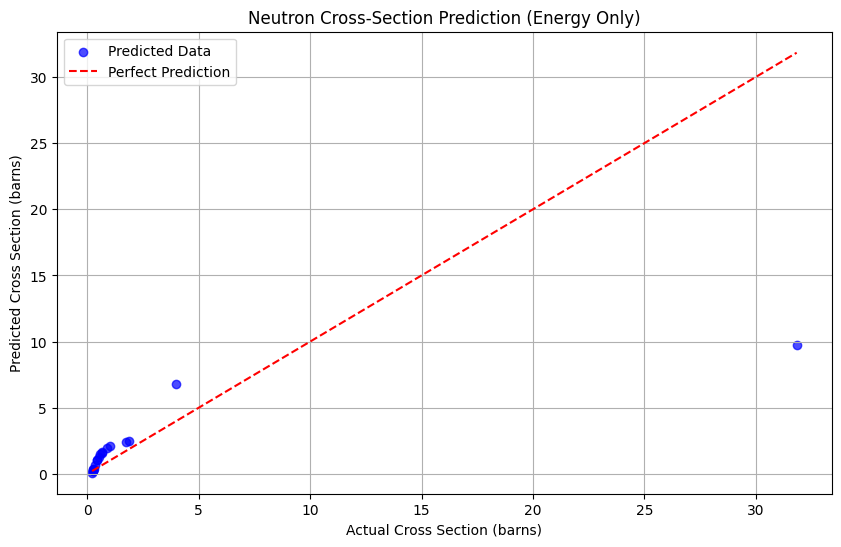

In [ ]:
main('1')

In [ ]:
main('2')

### Spline interpolation

In [ ]:
## Pseudocode

In [ ]:
## Failed test-cases

### B-spline interpolation

To provide a comprehensive understanding of Non-Uniform Rational B-Splines (NURBS) by building from the foundational concepts of splines, B-splines, and rational B-splines, we will include assumptions and constraints for each method's input dataset. This will help clarify when and how each representation is best utilized.

### 1. Splines

**Definition**:
A spline is a piecewise polynomial function used to create smooth curves through a set of data points.

**Assumptions**:
- The input dataset consists of a finite number of points that are expected to be connected smoothly.
- The data points should ideally be evenly spaced or sufficiently dense to avoid large gaps.

**Constraints**:
- The degree of the polynomial used in the spline affects the smoothness of the curve. Higher-degree polynomials may lead to oscillations (Runge's phenomenon) if not properly controlled.



Cubic spline interpolation is a method used to construct a smooth curve through a set of data points. The curve is represented by piecewise cubic polynomials, ensuring continuity and smoothness at the data points. Below is a mathematical explanation of how the coefficients of cubic splines are calculated.

## Mathematical Explanation of Cubic Spline Coefficient Calculation

### Definition of Cubic Splines

A cubic spline consists of $n-1$ cubic polynomial segments $$S_i(x)$$ defined over intervals $$[x_i, x_{i+1}]$$ for $$i = 0, 1,\ldots,n-2$$. Each segment can be expressed as:

$$S_i(x) = a_i (x - x_i)^3 + b_i (x - x_i)^2 + c_i (x - x_i) + d_i$$

where $$a_i, b_i, c_i, d_i$$ are the coefficients for the $$i$$-th polynomial segment.

### Number of Coefficients

For $$ n $$ data points, there are $$n-1$$ cubic polynomials, leading to a total of:$$4(n-1)$$, unknown coefficients ($$a_i, b_i, c_i, d_i$$).

### Conditions for Coefficients

To determine these coefficients, we need to establish a system of equations based on the following conditions:

1. **Interpolation Conditions**: Each polynomial must pass through its corresponding data points:
   - For each interval, we have: $$S_i(x_i) = y_i$$, $$S_i(x_{i+1}) = y_{i+1}$$
   This gives us $$2(n-1)$$ equations.

2. **Continuity Conditions**: The splines must be continuous at the interior points:
   - At each interior node $$x_{i}$$: $$S_{i-1}(x_{i}) = S_{i}(x_{i})$$

3. **Smoothness Conditions**: The first and second derivatives of adjacent splines must match at the interior nodes:
   - First derivative:
     $$S'_{i-1}(x_{i}) = S'_{i}(x_{i})$$
   - Second derivative:
     $$S''_{i-1}(x_{i}) = S''_{i}(x_{i})$$

4. **Boundary Conditions**: Additional conditions are required to solve the system completely. Common choices include:
   - **Natural spline**: Set the second derivatives at the endpoints to zero:
     $$S''_0(x_0) = 0$$, $$S''_{n-2}(x_{n-1}) = 0$$

### Formulating the System of Equations

The conditions lead to a system of linear equations that can be represented in matrix form. The equations can be derived as follows:

In cubic spline interpolation, ensuring continuity and smoothness at the interior points involves establishing relationships between the coefficients of the cubic polynomials defined over each interval. The following equations summarize these conditions mathematically.

### 1. Continuity Condition

For two adjacent cubic spline segments $$ S_i(x) $$ and $$ S_{i+1}(x) $$, the continuity condition requires that both segments meet at the interior knot $$ x_i $$. This can be expressed as:

$$
S_i(x_i) = S_{i+1}(x_i)
$$

This means that the value of the spline at $$ x_i $$ from both segments must be equal.

### 2. First Derivative Continuity

The first derivative of the splines must also be continuous at the interior knots. This ensures that there are no sharp corners in the spline. Mathematically, this is expressed as:

$$
S'_i(x_i) = S'_{i+1}(x_i)
$$

This condition ensures that the slopes of the two adjacent segments are equal at $$ x_i $$.

### 3. Second Derivative Continuity

The second derivatives of the splines must also be continuous at the interior knots to ensure smoothness of curvature. This is expressed as:

$$
S''_i(x_i) = S''_{i+1}(x_i)
$$

This condition guarantees that the curvature of the spline is consistent across adjacent segments.

### Summary of Equations

Given a cubic polynomial representation for each segment:

$$
S_i(x) = a_i + b_i (x - x_i) + c_i (x - x_i)^2 + d_i (x - x_i)^3
$$
for $$ i = 0, 1, \ldots, n-2 $$, we can summarize the conditions as follows:

1. **Value Continuity**:
   $$
   a_i + b_i (x_i - x_i) + c_i (x_i - x_i)^2 + d_i (x_i - x_i)^3 = a_{i+1} + b_{i+1} (x_i - x_{i+1}) + c_{i+1} (x_i - x_{i+1})^2 + d_{i+1} (x_i - x_{i+1})^3
   $$

2. **First Derivative Continuity**:
   $$
   b_i + 2c_i (x_i - x_i) + 3d_i (x_i - x_i)^2 = b_{i+1} + 2c_{i+1} (x_i - x_{i+1}) + 3d_{i+1} (x_i - x_{i+1})^2
   $$

3. **Second Derivative Continuity**:
   $$
   2c_i + 6d_i (x_i - x_i) = 2c_{i+1} + 6d_{i+1} (x_i - x_{i+1})
   $$

4. **Applying the Boundary Conditions**:

    1. **At $$ x_0 $$**:
   - For the first segment $$ S_0(x) $$:
   $$
   S_0''(x_0) = 2c_0 + 6d_0 (x_0 - x_0) = 2c_0 = 0
   $$
   Thus, we have:
   $$
   c_0 = 0
   $$

   2. **At $$ x_{n-1} $$**:
   - For the last segment $$ S_{n-2}(x) $$:
   $$
   S_{n-2}''(x_{n-1}) = 2c_{n-2} + 6d_{n-2} (x_{n-1} - x_{n-2}) = 0
   $$
   This gives us:
   $$
   2c_{n-2} + 6d_{n-2} h_{n-2} = 0
   $$
   where $$ h_{n-2} = x_{n-1} - x_{n-2} $$.


### Solving the System

The resulting system can often be expressed in a tridiagonal matrix form, which is efficient to solve using methods like Gaussian elimination or specialized algorithms for tridiagonal systems.

The tridiagonal matrix used in cubic spline interpolation arises from the conditions imposed on the spline coefficients to ensure continuity and smoothness at the data points. Below is the mathematical formulation of this tridiagonal matrix.

### Structure of the Tridiagonal Matrix

For a set of $$ n $$ data points $$ (x_0, y_0), (x_1, y_1), \ldots, (x_{n-1}, y_{n-1}) $$, we define the following:

- Let $$ h_i = x_{i+1} - x_i $$ for $$ i = 0, 1, \ldots, n-2 $$.
- Let $$ c_i $$ be the second derivative of the spline at point $$ x_i $$.

The conditions for cubic splines lead to a system of equations that can be represented in a tridiagonal matrix form. The general form of the tridiagonal matrix $$ A $$ is as follows:

$$
A =
\begin{bmatrix}
1 & 0 & 0 & \cdots & 0 & 0 \\
h_0 & 2(h_0 + h_1) & h_1 & \cdots & 0 & 3\left(\frac{y_2 - y_1}{h_1} - \frac{y_1 - y_0}{h_0}\right) \\
0 & h_1 & 2(h_1 + h_2) & \cdots & 0 & 3\left(\frac{y_3 - y_2}{h_2} - \frac{y_2 - y_1}{h_1}\right) \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & 0 & \cdots & h_{n-2} & 2(h_{n-2} + h_{n-1}) \\
0 & 0 & 0 & \cdots & h_{n-1} & 1
\end{bmatrix}
$$

### Explanation of Matrix Elements

- **Diagonal Elements**: The main diagonal elements are $$ 2(h_i + h_{i+1}) $$ for $$ i = 1, 2, ..., n-2 $$, which represent the influence of adjacent intervals on the second derivative at each knot.
  
- **Subdiagonal and Superdiagonal Elements**: The elements directly below and above the main diagonal are $$ h_i $$, which represent the spacing between consecutive knots.

- **Right-Hand Side Vector**: The right-hand side vector consists of the values derived from the continuity of first derivatives between adjacent splines:
  
$$
b =
\begin{bmatrix}
0 \\
3\left(\frac{y_2 - y_1}{h_1} - \frac{y_1 - y_0}{h_0}\right) \\
3\left(\frac{y_3 - y_2}{h_2} - \frac{y_2 - y_1}{h_1}\right) \\
\vdots \\
3\left(\frac{y_{n-1} - y_{n-2}}{h_{n-2}} - \frac{y_{n-2} - y_{n-3}}{h_{n-3}}\right)\\
0
\end{bmatrix}
$$

### Solving the System

To find the coefficients $$ c_i $$, we solve the system $$ A c = b $$, where:
- $$ c = [c_0, c_1, ..., c_{n-1}]^T $$
- $$ b = [b_0, b_1, ..., b_{n-1}]^T $$

Once we have computed $$ c_i $$, we can derive the coefficients $$ b_i $$ and $$ d_i $$ for each cubic polynomial segment using:

$$
b_i = \frac{y_{i+1} - y_i}{h_i} - h_i\left(\frac{c_{i+1} + 2c_i}{3}\right)
$$
$$
d_i = \frac{c_{i+1} - c_i}{3h_i}
$$

### Conclusion

This tridiagonal matrix structure efficiently encapsulates the conditions required for cubic spline interpolation. By solving this matrix equation, we can determine all necessary coefficients to construct a smooth piecewise cubic polynomial that interpolates through given data points.

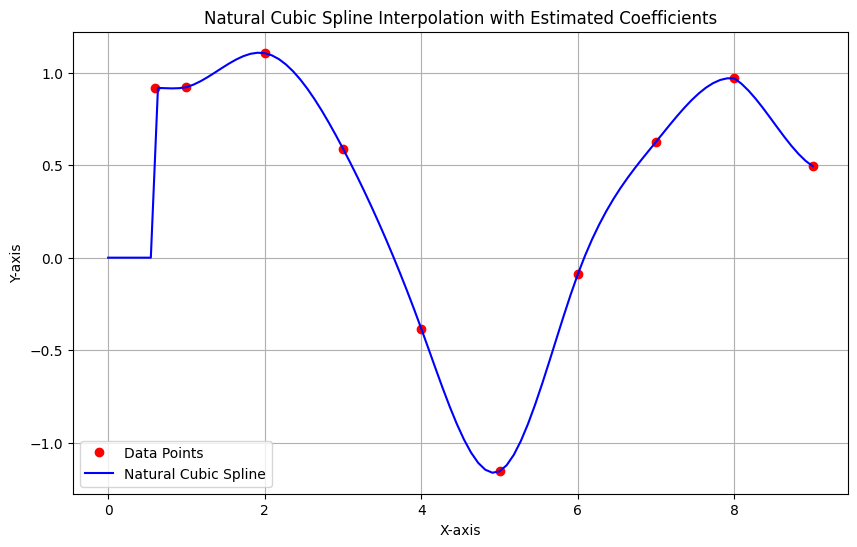

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded

def natural_cubic_spline(x, y):
    n = len(x)
    h = np.diff(x)  # Differences between x values

    # Set up the coefficients for the tridiagonal matrix
    lower_diag = np.zeros(n - 1)  # sub-diagonal (lower)
    main_diag = np.zeros(n)        # main diagonal
    upper_diag = np.zeros(n - 1)  # super-diagonal (upper)

    # Populate the tridiagonal matrix
    main_diag[0] = 1  # Natural spline boundary condition
    for i in range(1, n - 1):
        lower_diag[i - 1] = h[i - 1]
        main_diag[i] = 2 * (h[i - 1] + h[i])
        upper_diag[i] = h[i]

    main_diag[n - 1] = 1  # Natural spline boundary condition

    # Set up the right-hand side vector
    rhs = np.zeros(n)
    rhs[1:n-1] = [(3 / h[i]) * (y[i + 1] - y[i]) - (3 / h[i - 1]) * (y[i] - y[i - 1]) for i in range(1, n - 1)]

    # Solve the tridiagonal system using scipy's solve_banded
    ab = np.zeros((3, n))  # Create a banded matrix
    ab[0, 1:n] = lower_diag   # Lower diagonal
    ab[1, :] = main_diag      # Main diagonal
    ab[2, :-1] = upper_diag    # Upper diagonal

    c = solve_banded((1, 1), ab, rhs)  # Solve for c coefficients

    b = np.zeros(n - 1)
    d = np.zeros(n - 1)

    # Calculate b and d coefficients
    for i in range(n - 1):
        b[i] = (y[i + 1] - y[i]) / h[i] - h[i] * (c[i + 1] + 2 * c[i]) / 3
        d[i] = (c[i + 1] - c[i]) / (3 * h[i])

    return b, c[:-1], d, y[:-1]

# Generating sample input data with noise
np.random.seed(0)  # For reproducibility
#x_points = np.linspace(0, 9, 10)          # x values from 0 to 9
x_points = np.array([0.6, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y_points = np.sin(x_points) + np.random.normal(0, 0.2, size=x_points.shape) # y values with some noise

# Compute cubic spline coefficients
b, c, d, y_vals = natural_cubic_spline(x_points, y_points)

# Plotting the spline
x_new = np.linspace(0, 9, 100)
y_new = np.zeros_like(x_new)

for i in range(len(x_points) - 1):
    idx = np.where((x_new >= x_points[i]) & (x_new <= x_points[i + 1]))[0]
    y_new[idx] = y_vals[i] + b[i]*(x_new[idx]-x_points[i]) + \
                  c[i]*(x_new[idx]-x_points[i])**2 + \
                  d[i]*(x_new[idx]-x_points[i])**3
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(x_points, y_points, 'ro', label='Data Points')
plt.plot(x_new, y_new, 'b-', label='Natural Cubic Spline')
plt.title('Natural Cubic Spline Interpolation with Estimated Coefficients')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid()
plt.show()


### 2. B-Splines

**Definition**:
B-splines are a generalization of splines that use control points and a knot vector to define piecewise polynomial functions. They provide local control over the shape of the curve.

**Assumptions**:
- The input dataset includes control points that define the shape of the curve.
- The knot vector must be non-decreasing and should partition the parameter space appropriately.

**Constraints**:
- The B-spline basis functions must form a partition of unity:
  $$
  \sum_{i=0}^{m-p-1} B_{i,p}(t) = 1
  $$
- The knot vector must have specific properties (e.g., internal knots must cover the domain of interest).

**Example**:
Consider four control points:
- $$ P_0 = (0, 0) $$
- $$ P_1 = (1, 2) $$
- $$ P_2 = (2, 0) $$
- $$ P_3 = (3, 3) $$

With a cubic B-spline degree $$ p=3 $$ and knot vector:
$$
T = [0, 0, 0, 0, 1, 2, 3, 4]
$$

The basis functions can be calculated recursively using de Boor's algorithm.

**Basis Functions**:
   - The B-spline basis functions $$ N_{i,p}(t) $$ are defined recursively using the following rules:

   - **Base Case (Degree 0)**:
     For $$ p = 0 $$:
     $$
     N_{i,0}(t) =
     \begin{cases}
     1 & \text{if } t_i \leq t < t_{i+1} \\
     0 & \text{otherwise}
     \end{cases}
     $$
     This means that each basis function is constant and equal to 1 within its interval defined by the knots.

   - **Recursive Definition (Higher Degrees)**:
     For $$ p > 0 $$:
     $$
     N_{i,p}(t) = \frac{t - t_i}{t_{i+p} - t_i} N_{i,p-1}(t) + \frac{t_{i+p+1} - t}{t_{i+p+1} - t_{i+1}} N_{i+1,p-1}(t)
     $$
     This equation combines two lower-degree basis functions to create a higher-degree basis function. The terms in the equation ensure that the basis functions are non-negative and that they sum to 1 over each interval.



![Basis functions](https://web.mit.edu/hyperbook/Patrikalakis-Maekawa-Cho/img365.gif)

 - **B-Spline Curve Definition**:
     - A B-spline curve $$ C(t) $$ can be expressed as a linear combination of control points $$ P_i $$ weighted by their corresponding basis functions:
   $$
   C(t) = \sum_{i=0}^{n} P_i N_{i,p}(t)
   $$
   where $$ n $$ is the number of control points minus one.

### Few remark:
 1. ReLU activations and B-spline basis functions: they both introduce non-linear behavior through piecewise definitions and recursive combinations. This similarity illustrates how non-linearity is a powerful tool in both neural networks (for learning complex patterns) and geometric modeling (for creating smooth curves). While they operate in different domains—one primarily in machine learning and the other in computer graphics and geometric modeling—the underlying principles of achieving non-linearity through local control and piecewise definitions -> https://github.com/joaquimcampos/DeepSplines

 2. All above curves could be generated using B-splines.

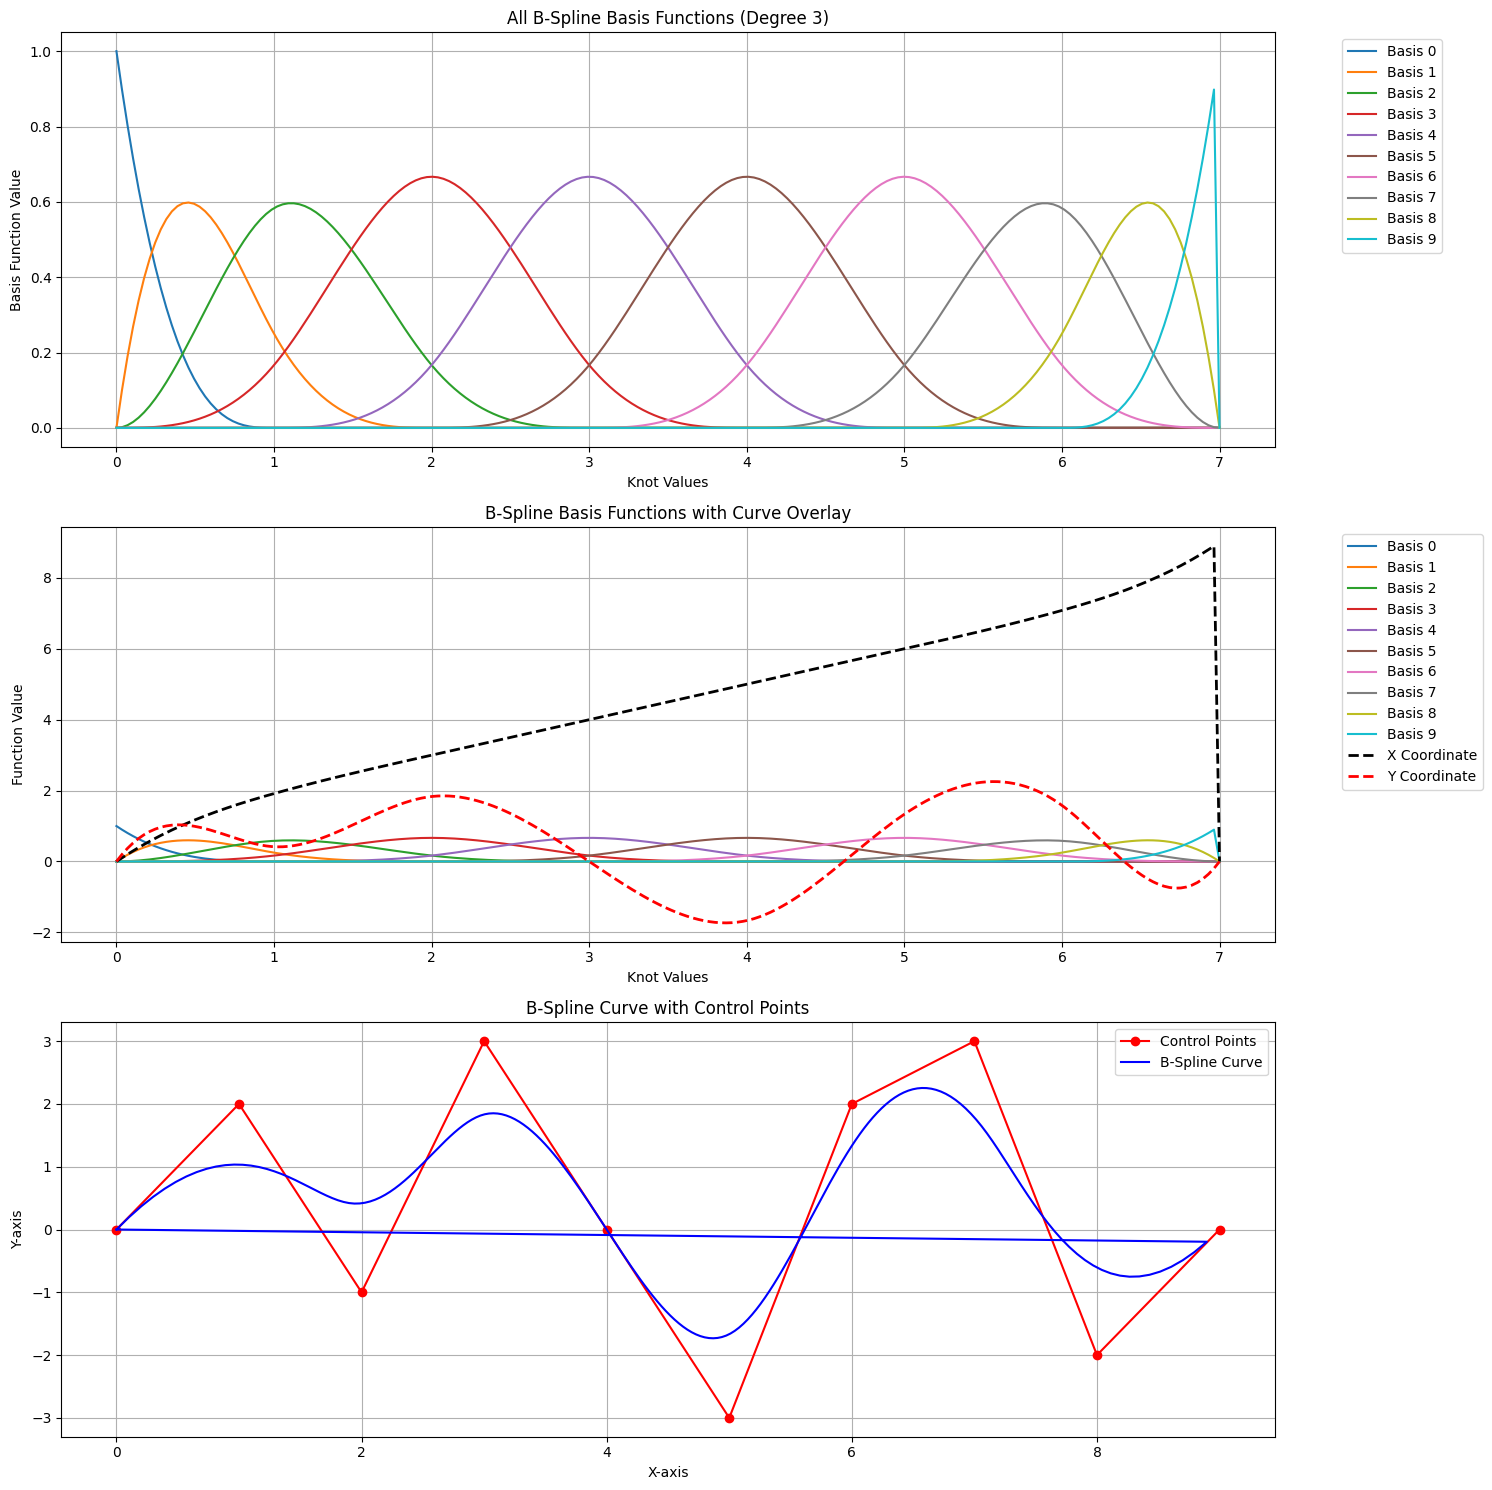

Knot Vector: [0 0 0 0 1 2 3 4 5 6 7 7 7 7]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def b_spline_basis(i, k, u, knots):
    if k == 0:
        return float(knots[i] <= u < knots[i + 1])

    denom_1 = knots[i + k] - knots[i]
    term_1 = (b_spline_basis(i, k - 1, u, knots) *
              ((u - knots[i]) / denom_1)) if denom_1 > 0 else 0

    denom_2 = knots[i + k + 1] - knots[i + 1]
    term_2 = (b_spline_basis(i + 1, k - 1, u, knots) *
              ((knots[i + k + 1] - u) / denom_2)) if denom_2 > 0 else 0

    return term_1 + term_2

def b_spline_curve(control_points, degree=3):
    n = len(control_points)
    m = n + degree + 1
    knots = np.concatenate(([0]*degree, np.arange(n-degree+1), [n-degree]*degree))

    u_values = np.linspace(knots[0], knots[-1], num=200)
    curve_points = []

    for u in u_values:
        point = sum(b_spline_basis(i, degree, u, knots) * control_points[i]
                    for i in range(n))
        curve_points.append(point)

    return np.array(curve_points), u_values, knots

# Generating 10 input points (control points)
control_pts = np.array([[0, 0], [1, 2], [2, -1], [3, 3], [4, 0],
                         [5, -3], [6, 2], [7, 3], [8, -2], [9, 0]])

# Compute B-spline curve from control points
curve_pts, u_values, knots = b_spline_curve(control_pts)

# Plotting results
plt.figure(figsize=(15, 15))

# All basis functions subplot
plt.subplot(3, 1, 1)
n = len(control_pts)
degree = 3
basis_knots = np.concatenate(([0]*degree, np.arange(n-degree+1), [n-degree]*degree))

# Plot all basis functions
for i in range(n):
    basis_values = [b_spline_basis(i, degree, u, basis_knots) for u in u_values]
    plt.plot(u_values, basis_values, label=f'Basis {i}')

plt.title(f'All B-Spline Basis Functions (Degree {degree})')
plt.xlabel('Knot Values')
plt.ylabel('Basis Function Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Basis functions with B-spline curve overlay
plt.subplot(3, 1, 2)
for i in range(len(control_pts)):
    basis_values = [b_spline_basis(i, 3, u, knots) for u in u_values]
    plt.plot(u_values, basis_values, label=f'Basis {i}')

# Overlay B-spline curve coordinates
plt.plot(u_values, curve_pts[:, 0], 'k--', linewidth=2, label='X Coordinate')
plt.plot(u_values, curve_pts[:, 1], 'r--', linewidth=2, label='Y Coordinate')

plt.title('B-Spline Basis Functions with Curve Overlay')
plt.xlabel('Knot Values')
plt.ylabel('Function Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# B-spline curve with control points
plt.subplot(3, 1, 3)
plt.plot(control_pts[:, 0], control_pts[:, 1], 'ro-', label='Control Points')
plt.plot(curve_pts[:, 0], curve_pts[:, 1], 'b-', label='B-Spline Curve')
plt.title('B-Spline Curve with Control Points')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print knot vector for reference
print("Knot Vector:", basis_knots)


## Uniform knot values

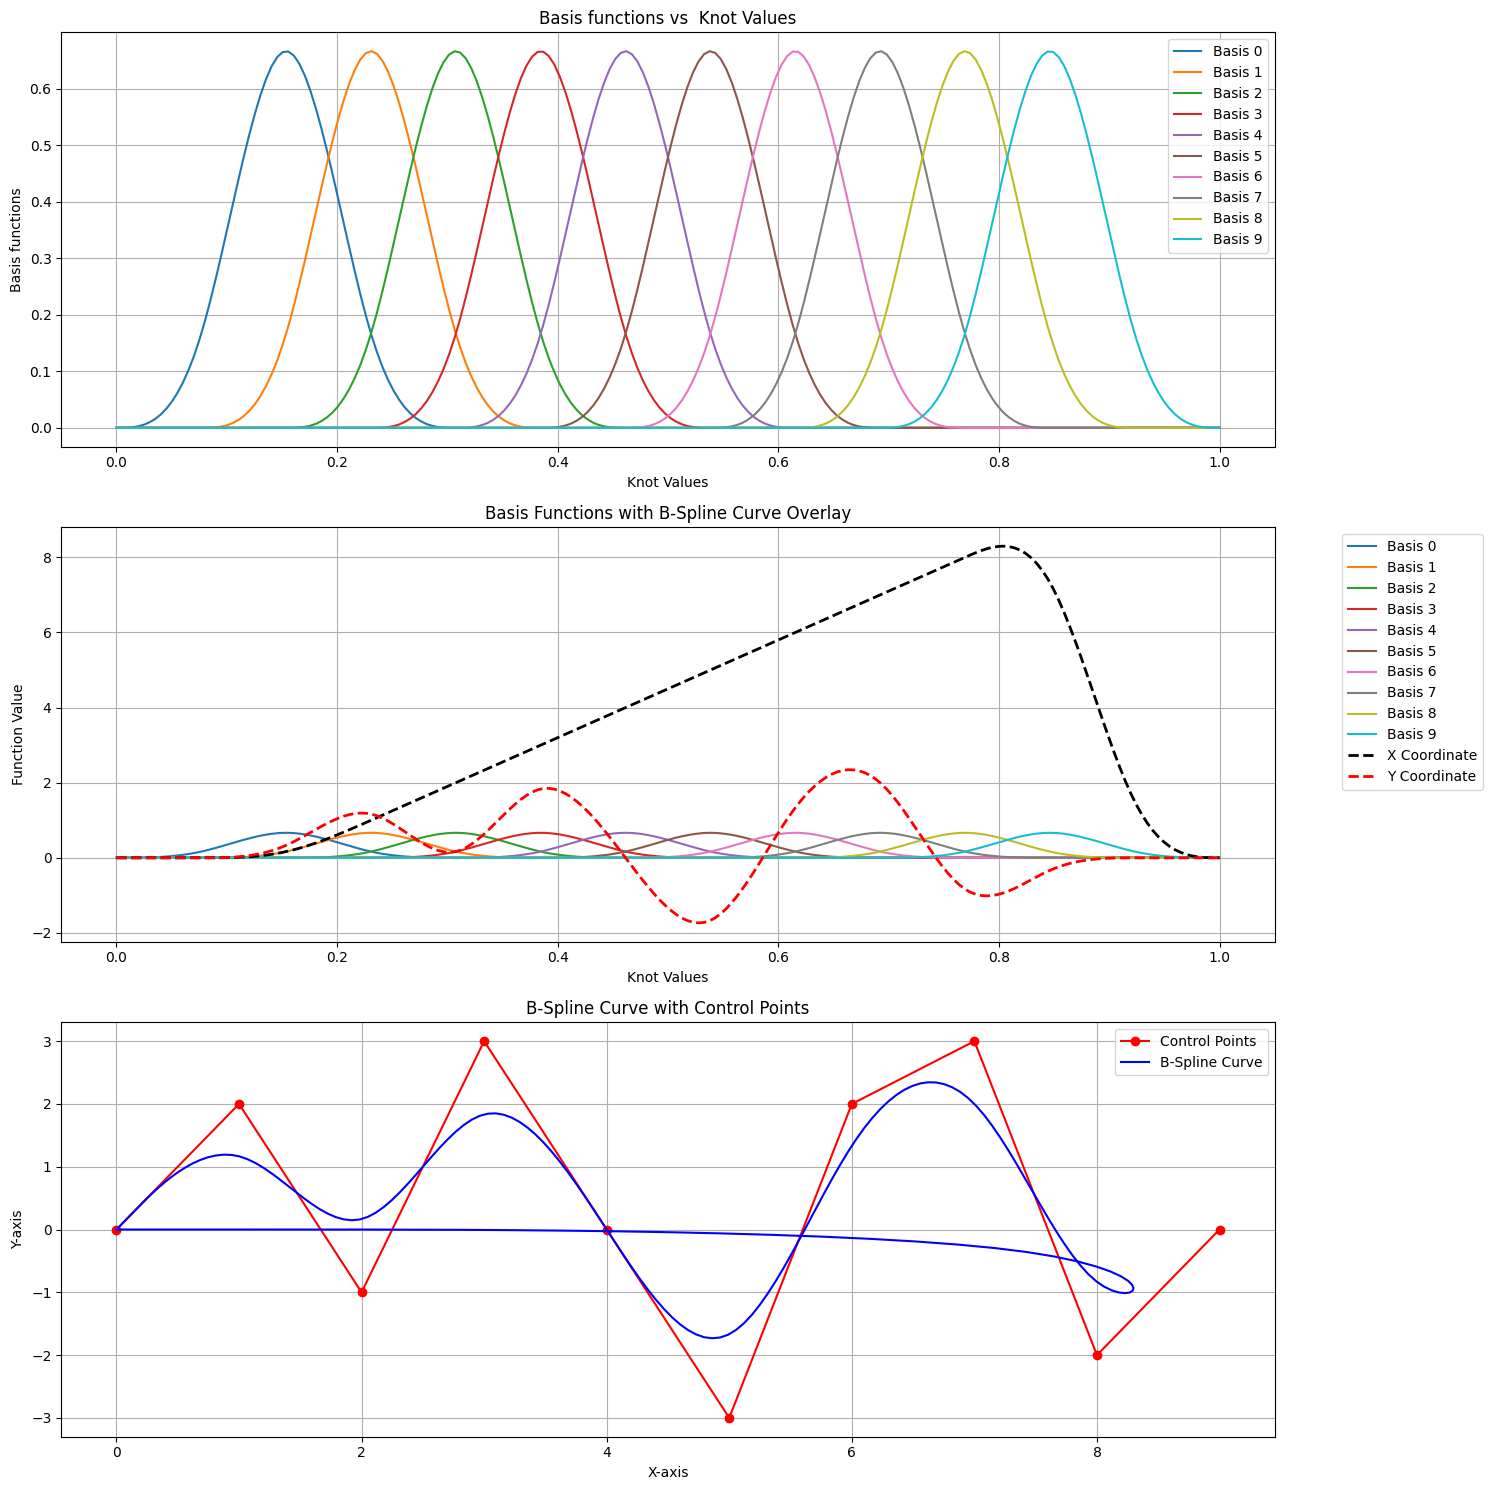

Distinct Knot Vector: [0.         0.07692308 0.15384615 0.23076923 0.30769231 0.38461538
 0.46153846 0.53846154 0.61538462 0.69230769 0.76923077 0.84615385
 0.92307692 1.        ]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def b_spline_basis(i, k, u, knots):
    if k == 0:
        return float(knots[i] <= u < knots[i + 1])

    denom_1 = knots[i + k] - knots[i]
    term_1 = (b_spline_basis(i, k - 1, u, knots) *
              ((u - knots[i]) / denom_1)) if denom_1 > 0 else 0

    denom_2 = knots[i + k + 1] - knots[i + 1]
    term_2 = (b_spline_basis(i + 1, k - 1, u, knots) *
              ((knots[i + k + 1] - u) / denom_2)) if denom_2 > 0 else 0

    return term_1 + term_2

def b_spline_curve(control_points, degree=3):
    n = len(control_points)

    '''
    # Distinct knot vector generation
    distinct_knots = np.unique(np.concatenate([
        [0]*degree,
        np.linspace(0, 1, n-degree+1),
        [1]*degree
    ]))
    '''

    # Uniform knot vector generation
    distinct_knots = np.linspace(0, 1, n+degree+1)

    u_values = np.linspace(distinct_knots[0], distinct_knots[-1], num=200)
    curve_points = []

    for u in u_values:
        point = sum(b_spline_basis(i, degree, u, distinct_knots) * control_points[i]
                    for i in range(n))
        curve_points.append(point)

    return np.array(curve_points), u_values, distinct_knots

# Generating 10 input points (control points)
control_pts = np.array([[0, 0], [1, 2], [2, -1], [3, 3], [4, 0],
                         [5, -3], [6, 2], [7, 3], [8, -2], [9, 0]])

# Compute B-spline curve from control points
curve_pts, u_values, distinct_knots = b_spline_curve(control_pts)

# Plotting results
plt.figure(figsize=(15, 15))

# Distinct Knot Values vs Basis Functions
plt.subplot(3, 1, 1)
# Plot basis functions
for i in range(n):
    basis_values = [b_spline_basis(i, degree, u, distinct_knots) for u in u_values]
    plt.plot(u_values, basis_values, label=f'Basis {i}')
plt.title('Basis functions vs  Knot Values')
plt.xlabel('Knot Values')
plt.ylabel('Basis functions')
plt.legend()
plt.grid(True)

# Basis Functions and B-Spline Curve
plt.subplot(3, 1, 2)
n = len(control_pts)
degree = 3

# Plot basis functions
for i in range(n):
    basis_values = [b_spline_basis(i, degree, u, distinct_knots) for u in u_values]
    plt.plot(u_values, basis_values, label=f'Basis {i}')

# Overlay B-spline curve coordinates
plt.plot(u_values, curve_pts[:, 0], 'k--', linewidth=2, label='X Coordinate')
plt.plot(u_values, curve_pts[:, 1], 'r--', linewidth=2, label='Y Coordinate')

plt.title('Basis Functions with B-Spline Curve Overlay')
plt.xlabel('Knot Values')
plt.ylabel('Function Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# B-spline curve with control points
plt.subplot(3, 1, 3)
plt.plot(control_pts[:, 0], control_pts[:, 1], 'ro-', label='Control Points')
plt.plot(curve_pts[:, 0], curve_pts[:, 1], 'b-', label='B-Spline Curve')
plt.title('B-Spline Curve with Control Points')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print distinct knot vector for reference
print("Distinct Knot Vector:", distinct_knots)


## Non uniform knot values

No. of knots:  14


<Figure size 2000x2000 with 0 Axes>

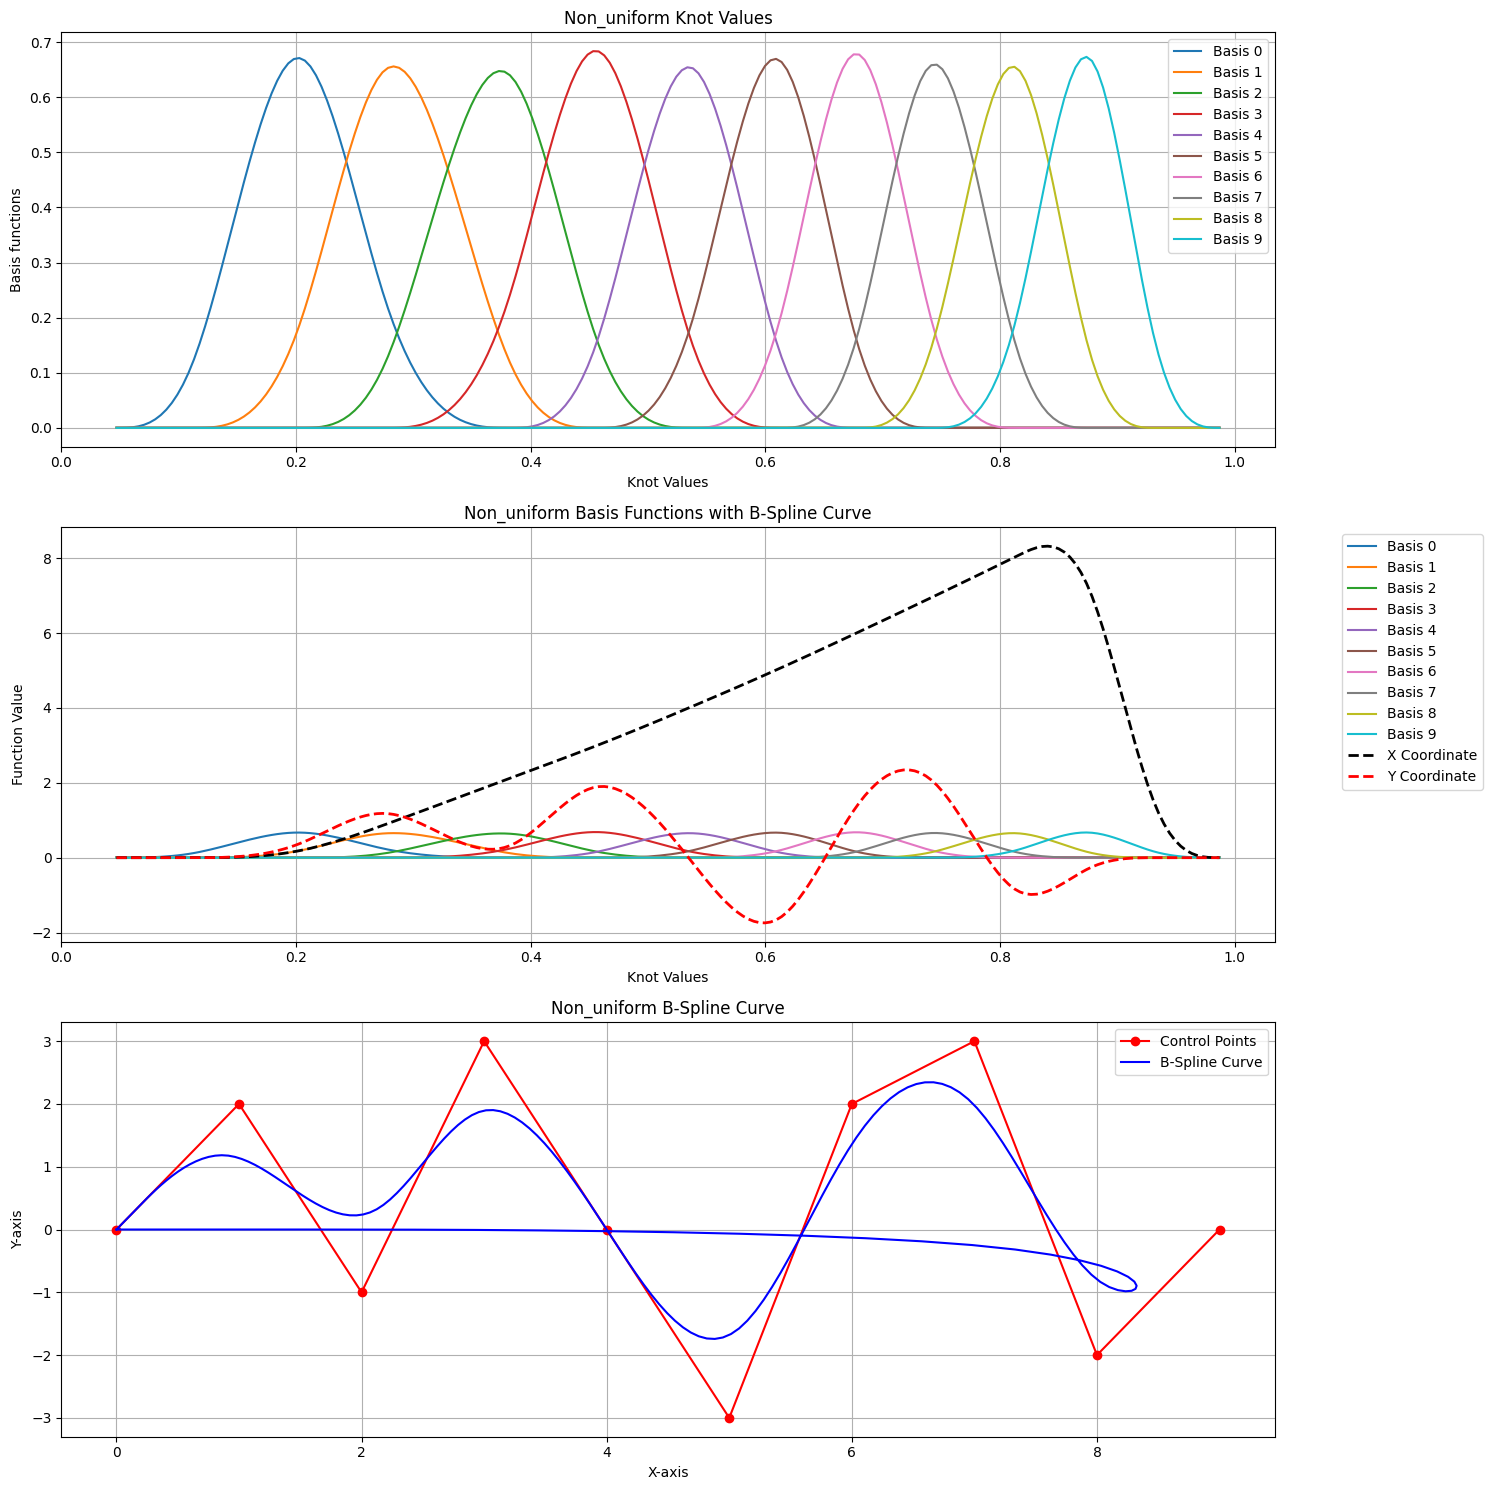

Non-Uniform Knot Vector: [0.047 0.112 0.203 0.276 0.382 0.456 0.537 0.612 0.678 0.743 0.814 0.876
 0.932 0.987]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def b_spline_basis(i, k, u, knots):
    if k == 0:
        return float(knots[i] <= u < knots[i + 1])

    denom_1 = knots[i + k] - knots[i]
    term_1 = (b_spline_basis(i, k - 1, u, knots) *
              ((u - knots[i]) / denom_1)) if denom_1 > 0 else 0

    denom_2 = knots[i + k + 1] - knots[i + 1]
    term_2 = (b_spline_basis(i + 1, k - 1, u, knots) *
              ((knots[i + k + 1] - u) / denom_2)) if denom_2 > 0 else 0

    return term_1 + term_2

def b_spline_curve(control_points, degree=3, knot_type='non_uniform'):
    n = len(control_points)

    # Non-uniform knot vector generation
    if knot_type == 'non_uniform':
        # Custom non-uniform knot distribution
        non_uniform_knots = np.array([0.047, 0.112, 0.203, 0.276, 0.382, 0.456, 0.537, 0.612, 0.678, 0.743, 0.814, 0.876, 0.932, 0.987])  # Non-uniform intermediate knots
        distinct_knots = np.unique(non_uniform_knots)
        print("No. of knots: ", len(distinct_knots))
    elif knot_type == 'uniform':
        distinct_knots = np.linspace(0, 1, n + degree + 1)
        print("No. of knots uniform: ", len(distinct_knots))
    u_values = np.linspace(distinct_knots[0], distinct_knots[-1], num=200)
    curve_points = []

    for u in u_values:
        point = sum(b_spline_basis(i, degree, u, distinct_knots) * control_points[i]
                    for i in range(n))
        curve_points.append(point)

    return np.array(curve_points), u_values, distinct_knots

# Generating 10 input points (control points)
control_pts = np.array([[0, 0], [1, 2], [2, -1], [3, 3], [4, 0],
                         [5, -3], [6, 2], [7, 3], [8, -2], [9, 0]])

# Plotting for both uniform and non-uniform knot distributions
plt.figure(figsize=(20, 20))

# Function to create subplots
def create_b_spline_plots(control_pts, knot_type, subplot_start):
    # Compute B-spline curve from control points
    curve_pts, u_values, distinct_knots = b_spline_curve(control_pts, knot_type=knot_type)

    # Plotting results
    plt.figure(figsize=(15, 15))

    # Distinct Knot Values vs Basis Functions
    plt.subplot(3, 1, 1)
    n = len(control_pts)
    degree = 3
    # Plot basis functions
    for i in range(n):
        basis_values = [b_spline_basis(i, degree, u, distinct_knots) for u in u_values]
        plt.plot(u_values, basis_values, label=f'Basis {i}')
    plt.title(f'{knot_type.capitalize()} Knot Values')
    plt.xlabel('Knot Values')
    plt.ylabel('Basis functions')
    plt.legend()
    plt.grid(True)

    # Basis Functions and B-Spline Curve
    plt.subplot(3, 1, 2)
    n = len(control_pts)
    degree = 3

    # Plot basis functions
    for i in range(n):
        basis_values = [b_spline_basis(i, degree, u, distinct_knots) for u in u_values]
        plt.plot(u_values, basis_values, label=f'Basis {i}')

    # Overlay B-spline curve coordinates
    plt.plot(u_values, curve_pts[:, 0], 'k--', linewidth=2, label='X Coordinate')
    plt.plot(u_values, curve_pts[:, 1], 'r--', linewidth=2, label='Y Coordinate')

    plt.title(f'{knot_type.capitalize()} Basis Functions with B-Spline Curve')
    plt.xlabel('Knot Values')
    plt.ylabel('Function Value')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)

    # B-spline curve with control points
    plt.subplot(3, 1, 3)
    plt.plot(control_pts[:, 0], control_pts[:, 1], 'ro-', label='Control Points')
    plt.plot(curve_pts[:, 0], curve_pts[:, 1], 'b-', label='B-Spline Curve')
    plt.title(f'{knot_type.capitalize()} B-Spline Curve')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()
    plt.grid(True)

    return distinct_knots

# Create plots for uniform and non-uniform knots
#uniform_knots = create_b_spline_plots(control_pts, 'uniform', 1)
non_uniform_knots = create_b_spline_plots(control_pts, 'non_uniform', 4)

plt.tight_layout()
plt.show()

# Print knot vectors
#print("Uniform Knot Vector:", uniform_knots)
print("Non-Uniform Knot Vector:", non_uniform_knots)


### Evaluating the degree of local control

<ipython-input-4-d0733b83533c>:26: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.math.comb(n, k) * (t**k) * ((1-t)**(n-k))


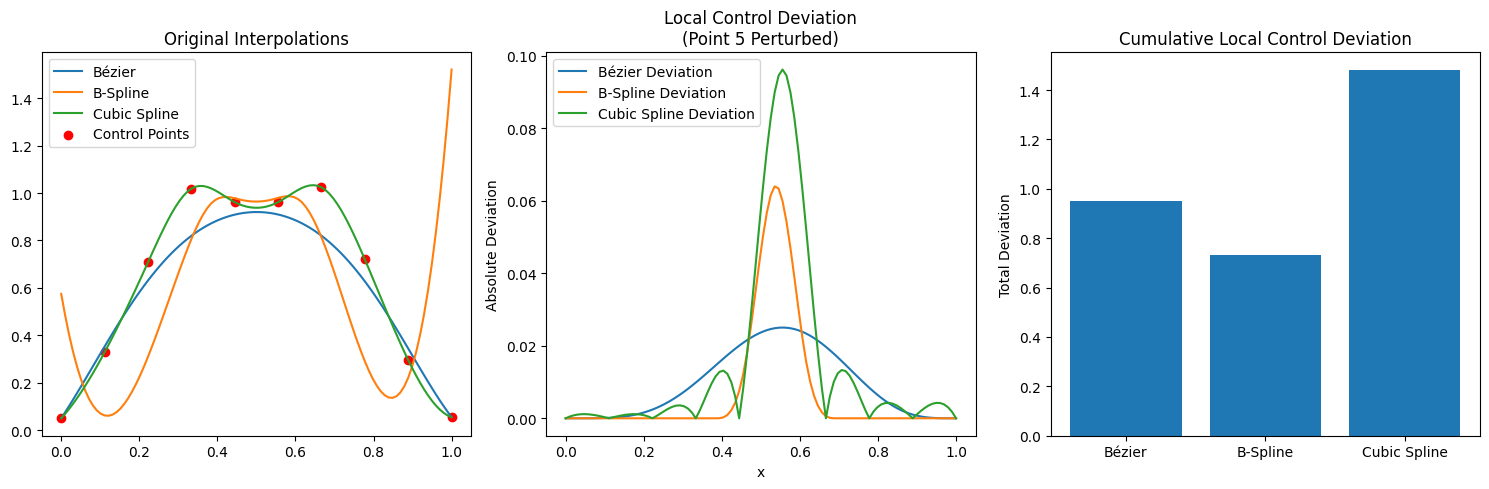

Bézier Total Deviation: 0.9517801167643359
B-Spline Total Deviation: 0.7321373051918243
Cubic Spline Total Deviation: 1.479428759680064

Most Localized Method: B-Spline


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline, CubicSpline

class CustomInterpolation:
    def __init__(self, x, y):
        self.x = x.copy()
        self.y = y.copy()

    def bezier_curve(self, x_eval):
        """Implement cubic Bézier curve with x-parametrization"""
        # Normalize x_eval to [0, 1]
        t = (x_eval - self.x.min()) / (self.x.max() - self.x.min())

        n = len(self.x)
        result = np.zeros_like(x_eval, dtype=float)

        for i in range(n):
            basis = self._bernstein_polynomial(i, n-1, t)
            result += self.y[i] * basis

        return result

    def _bernstein_polynomial(self, k, n, t):
        """Compute Bernstein polynomial"""
        return np.math.comb(n, k) * (t**k) * ((1-t)**(n-k))

    def cubic_bspline(self, x_eval):
        """Implement cubic B-Spline using knot vector"""
        # Create uniform knot vector
        t = np.linspace(0, 1, len(self.x) + 4)
        return BSpline(t, self.y, 3)(x_eval)

    def cubic_spline(self, x_eval):
        """Use CubicSpline interpolation"""
        return CubicSpline(self.x, self.y)(x_eval)

    def compute_local_control_deviation(self, perturb_index, perturbation_scale=0.1):
        """
        Compute local control deviation by perturbing a specific control point's y-value

        Args:
            perturb_index (int): Index of control point to perturb
            perturbation_scale (float): Magnitude of perturbation
        """
        # Create copies to avoid modifying original data
        y_perturbed = self.y.copy()

        # Perturb specific y value
        y_perturbed[perturb_index] *= (1 + perturbation_scale)

        # Evaluation points
        x_eval = np.linspace(self.x.min(), self.x.max(), 100)

        # Original interpolation
        y_bezier_orig = self.bezier_curve(x_eval)
        y_bspline_orig = self.cubic_bspline(x_eval)
        y_cubic_orig = self.cubic_spline(x_eval)

        # Temporary interpolation object with perturbed y data
        perturbed_interp = CustomInterpolation(self.x, y_perturbed)

        # Perturbed interpolation
        y_bezier_perturbed = perturbed_interp.bezier_curve(x_eval)
        y_bspline_perturbed = perturbed_interp.cubic_bspline(x_eval)
        y_cubic_perturbed = perturbed_interp.cubic_spline(x_eval)

        # Compute deviation
        bezier_deviation = np.abs(y_bezier_orig - y_bezier_perturbed)
        bspline_deviation = np.abs(y_bspline_orig - y_bspline_perturbed)
        cubic_deviation = np.abs(y_cubic_orig - y_cubic_perturbed)

        return (x_eval,
                bezier_deviation,
                bspline_deviation,
                cubic_deviation)

def main():
    # Generate sample datasets to highlight different behaviors
    np.random.seed(42)

    # Scenario 1: Smooth sinusoidal curve
    N = 10
    x = np.linspace(0, 1, N)
    y = np.sin(x * np.pi) + np.random.normal(0, 0.1, N)

    # Create interpolation instance
    interp = CustomInterpolation(x, y)

    # User-selected index to perturb (e.g., middle point)
    perturb_index = N // 2

    # Compute local control deviation
    x_plot, bezier_dev, bspline_dev, cubic_dev = interp.compute_local_control_deviation(perturb_index)

    # Visualization
    plt.figure(figsize=(15, 5))

    # Original points and curves
    plt.subplot(131)
    plt.title('Original Interpolations')
    x_curve = np.linspace(x.min(), x.max(), 100)
    plt.plot(x_curve, interp.bezier_curve(x_curve), label='Bézier')
    plt.plot(x_curve, interp.cubic_bspline(x_curve), label='B-Spline')
    plt.plot(x_curve, interp.cubic_spline(x_curve), label='Cubic Spline')
    plt.scatter(x, y, color='red', label='Control Points')
    plt.legend()

    # Deviation plots
    plt.subplot(132)
    plt.title(f'Local Control Deviation\n(Point {perturb_index} Perturbed)')
    plt.plot(x_plot, bezier_dev, label='Bézier Deviation')
    plt.plot(x_plot, bspline_dev, label='B-Spline Deviation')
    plt.plot(x_plot, cubic_dev, label='Cubic Spline Deviation')
    plt.xlabel('x')
    plt.ylabel('Absolute Deviation')
    plt.legend()

    # Cumulative deviation
    plt.subplot(133)
    plt.title('Cumulative Local Control Deviation')
    cumulative_devs = [np.sum(bezier_dev), np.sum(bspline_dev), np.sum(cubic_dev)]
    plt.bar(['Bézier', 'B-Spline', 'Cubic Spline'], cumulative_devs)
    plt.ylabel('Total Deviation')

    plt.tight_layout()
    plt.show()

    # Print total deviations and analysis
    method_names = ['Bézier', 'B-Spline', 'Cubic Spline']
    for name, dev in zip(method_names, cumulative_devs):
        print(f"{name} Total Deviation: {dev}")

    # Identify method with most localized response
    most_local_method = method_names[np.argmin(cumulative_devs)]
    print(f"\nMost Localized Method: {most_local_method}")

if __name__ == "__main__":
    main()


### 3. Rational B-Splines

**Definition**:
Rational B-splines extend B-splines by introducing weights for each control point. This allows for the representation of conic sections (like circles and ellipses), which cannot be achieved with standard B-splines.

**Assumptions**:
- The input dataset includes control points along with corresponding weights.
- The weights should be non-negative to ensure meaningful geometric interpretations.

**Constraints**:
- The rational function must maintain continuity and differentiability across segments.
  
**Example**:
Using the same control points as before but adding weights:
- $$ P_0 = (0, 0), w_0 = 1 $$
- $$ P_1 = (1, 2), w_1 = 2 $$
- $$ P_2 = (2, 0), w_2 = 1 $$
- $$ P_3 = (3, 3), w_3 = 1.5 $$

The rational B-spline curve can be represented as:
$$
C(u) = \frac{\sum_{i=0}^{n} w_i P_i N_{i,p}(u)}{\sum_{i=0}^{n} w_i N_{i,p}(u)}
$$

### 4. Non-Uniform Rational B-Splines (NURBS)

**Definition**:
NURBS are a specific type of rational B-spline that allows for non-uniform spacing of knots. This flexibility makes them extremely powerful for representing complex shapes in computer-aided design and graphics.

**Assumptions**:
- The input dataset includes control points with associated weights and a non-uniform knot vector.
- Control points should be placed strategically to achieve the desired shape.

**Constraints**:
- The knot vector must allow for non-uniform spacing while ensuring that the basis functions maintain continuity.
  
**Example**:
Consider the same control points with weights and a non-uniform knot vector:
$$
T = [0, 0, 0, 1, 2, 3, 4]
$$

Using these parameters in the NURBS formula allows for precise modeling of curves that can represent complex geometries such as arcs or intricate shapes.


To explain NURBS (Non-Uniform Rational B-Splines) surfaces in a bottom-up approach, we will start with spline surfaces, progress through B-spline surfaces, rational B-spline surfaces, and finally arrive at NURBS surfaces. Each section will include equations, assumptions, and Python code examples.

### 1. Spline Surfaces

**Definition**: A spline surface is a piecewise-defined surface that is constructed from polynomial functions. The simplest form is a Bézier surface, which is defined over a grid of control points.

**Equation**: A Bézier surface can be defined as:
$$
S(u, v) = \sum_{i=0}^{m} \sum_{j=0}^{n} P_{i,j} B_{i,p}(u) B_{j,q}(v)
$$
where:
- $$ P_{i,j} $$ are the control points,
- $$ B_{i,p}(u) $$ and $$ B_{j,q}(v) $$ are the Bézier basis functions of degree $$ p $$ and $$ q $$.

**Assumptions**:
- Control points define the shape of the surface.
- The parameters $$ u $$ and $$ v $$ range from 0 to 1.

**Python Code Example**:
```python
import numpy as np
import matplotlib.pyplot as plt

def bezier_surface(u, v, control_points):
    """ Calculate Bézier surface point for given u, v. """
    m = len(control_points) - 1  # Number of control points in u
    n = len(control_points[0]) - 1  # Number of control points in v
    S = np.zeros((3,))
    
    for i in range(m + 1):
        for j in range(n + 1):
            B_u = (u ** i) * ((1 - u) ** (m - i))  # Simplified Bézier basis for u
            B_v = (v ** j) * ((1 - v) ** (n - j))  # Simplified Bézier basis for v
            S += P[i][j] * B_u * B_v
            
    return S

# Control points for a simple surface
P = np.array([[[0, 0, 0], [1, 0, 0]],
               [[0, 1, 0], [1, 1, 1]]])

# Generate surface points
u_values = np.linspace(0, 1, 10)
v_values = np.linspace(0, 1, 10)
surface_points = np.array([[bezier_surface(u, v, P) for u in u_values] for v in v_values])

# Plotting the surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(surface_points[:,:,0], surface_points[:,:,1], surface_points[:,:,2])
plt.show()
```

### 2. B-Spline Surfaces

**Definition**: B-spline surfaces generalize Bézier surfaces by using a set of basis functions that allow for more flexibility and local control over the shape.

**Equation**: A B-spline surface is defined as:
$$
S(u,v) = \sum_{i=0}^{m} \sum_{j=0}^{n} P_{i,j} N_{i,p}(u) N_{j,q}(v)
$$
where:
- $$ N_{i,p}(u) $$ and $$ N_{j,q}(v) $$ are the B-spline basis functions of degree $$ p $$ and $$ q $$.

**Assumptions**:
- Control points form a grid.
- The knot vectors determine the parameterization.

**Python Code Example**:
```python
from scipy.interpolate import BSpline

def b_spline_surface(u, v, control_points, degree_u=3, degree_v=3):
    """ Calculate B-spline surface point for given u, v. """
    m = len(control_points) - 1
    n = len(control_points[0]) - 1
    
    # Create knot vectors
    knot_u = np.concatenate(([0] * degree_u, np.arange(m - degree_u + 2), [m - degree_u + 1] * degree_u))
    knot_v = np.concatenate(([0] * degree_v, np.arange(n - degree_v + 2), [n - degree_v + 1] * degree_v))

    # Create B-spline basis functions
    b_spline_u = BSpline(knot_u, control_points[:, :, 0].flatten(), degree_u)
    b_spline_v = BSpline(knot_v, control_points[:, :, 1].flatten(), degree_v)

    return b_spline_u(u), b_spline_v(v)

# Control points for a simple B-spline surface
control_points = np.array([[[0, 0], [1, 2]],
                            [[2, 3], [4, 5]]])

# Generate surface points using B-spline
u_values = np.linspace(0, 1, 10)
v_values = np.linspace(0, 1, 10)
surface_points_bspline = np.array([[b_spline_surface(u, v, control_points) for u in u_values] for v in v_values])

# Plotting the B-spline surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(surface_points_bspline[:,:,0], surface_points_bspline[:,:,1], surface_points_bspline[:,:,2])
plt.show()
```

### 3. Rational B-Spline Surfaces

**Definition**: Rational B-splines extend B-splines by introducing weights to the control points. This allows for the representation of conic sections and more complex shapes.

**Equation**: The rational B-spline surface is defined as:
$$
S(u,v) = \frac{\sum_{i=0}^{m} \sum_{j=0}^{n} w_{i,j} P_{i,j} N_{i,p}(u) N_{j,q}(v)}{\sum_{i=0}^{m} \sum_{j=0}^{n} w_{i,j} N_{i,p}(u) N_{j,q}(v)}
$$
where:
- $$ w_{i,j} $$ are the weights associated with each control point.

**Assumptions**:
- Weights can be adjusted to influence the shape.
- The same knot vector rules apply.

**Python Code Example**:
```python
def rational_b_spline_surface(u, v, control_points, weights):
    """ Calculate rational B-spline surface point for given u and v. """
    m = len(control_points) - 1
    n = len(control_points[0]) - 1
    
    # Create knot vectors
    knot_u = np.concatenate(([0] * (degree_u + 1), np.arange(m - degree_u + 2), [m - degree_u + 1] * (degree_u + 1)))
    knot_v = np.concatenate(([0] * (degree_v + 1), np.arange(n - degree_v + 2), [n - degree_v + 1] * (degree_v + 1)))

    # Calculate numerator and denominator separately
    numerator = sum(weights[i][j] * P[i][j] * N(i,u)*N(j,v)
                   for i in range(m+1)
                   for j in range(n+1))
    
    denominator = sum(weights[i][j] * N(i,u)*N(j,v)
                      for i in range(m+1)
                      for j in range(n+1))
    
    return numerator / denominator

# Control points and weights for a simple rational B-spline surface
weights = np.array([[1.0, 2.0],
                    [3.0, 4.0]])

# Generate rational B-spline surface points using weights
surface_points_rational_bspline = np.array([[rational_b_spline_surface(u,v,P,w) for u in u_values]
                                             for v in v_values])

# Plotting the rational B-spline surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(surface_points_rational_bspline[:,:,0],
                surface_points_rational_bspline[:,:,1],
                surface_points_rational_bspline[:,:,2])
plt.show()
```

### 4. Non-Uniform Rational B-Splines (NURBS)

**Definition**: NURBS surfaces extend rational B-splines by allowing non-uniform spacing of knots and maintaining all properties from previous forms.

**Equation**: The NURBS surface is defined as:
$$
S(u,v) = \frac{\sum_{i=0}^{m} \sum_{j=0}^{n} w_{i,j} P_{i,j} N_{i,p}(u) N_{j,q}(v)}{\sum_{i=0}^{m} \sum_{j=0}^{n} w_{i,j} N_{i,p}(u) N_{j,q}(v)}
$$
with non-uniform knot vectors.

**Assumptions**:
- Allows complex shapes with greater flexibility.
- Knot vectors can be non-uniformly spaced.

### Conclusion

This structured approach illustrates how spline surfaces evolve into more complex forms like NURBS through mathematical definitions and Python implementations. Each representation builds upon its predecessor while introducing new capabilities that enhance modeling flexibility and precision.

Citations:
[1] About NURBS https://www.maruf.ca/files/caadoc/CAAGobTechArticles/Nurbs.htm
[2] [PDF] B-Spline and NURBS Surfaces CS 525 ©Denbigh Starkey https://www.cs.montana.edu/courses/spring2009/525/dslectures/NURBSSurface.pdf
[3] Non-uniform rational B-spline - Wikipedia https://en.wikipedia.org/wiki/Non-uniform_rational_B-spline
[4] NURBS Surface -- from Wolfram MathWorld https://mathworld.wolfram.com/NURBSSurface.html
[5] An Introduction to NURBS Modeling – A Simple Guide - ThePro3DStudio https://professional3dservices.com/blog/nurbs-modeling.html
[6] What is NURBS modeling and why is it crucial to CAD software?www.3ds.com › ... › CAD https://www.3ds.com/store/cad/nurbs-modeling
[7] NURBS Terminology - 3ds Max 2017 - Autodesk Help https://help.autodesk.com/cloudhelp/2017/ENU/Max-SDK/files/GUID-B2367ED2-E5E0-499C-90C8-7263CBBD2B1B.htm

## Reflections

### Which one to use when?
1. How these methods compare with other interpolation methods?
2. Can we use these methods instead of ML models?